# Test GRIK Trial 01 - Following Example code (Transfer Learning)

In [1]:
%matplotlib inline

In [2]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

In [3]:
data_transforms = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

data_dir = 'leeDataset'
train_set = datasets.ImageFolder(os.path.join(data_dir, 'train'), data_transforms)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=4, shuffle=True, num_workers=4)
test_set = datasets.ImageFolder(os.path.join(data_dir, 'val'), data_transforms)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=4, shuffle=False, num_workers=4)

# dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = train_set.classes
print(class_names)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

['handwrite', 'text']


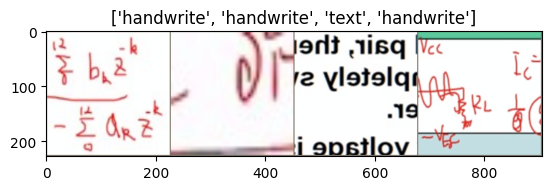

In [4]:
# Visualize a few images
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [6]:
## Define Training part - training and testing at once & saving best performance model

def training(model, device, train_loader, test_loader, optimizer, criterion, scheduler, num_epochs):
  best_acc = 0


  best_model_wts = copy.deepcopy(model.state_dict())
  for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0
    train_acc = 0
    for batch_idx, (data, target) in enumerate(train_loader):
      data, target = data.to(device), target.to(device)
      optimizer.zero_grad()
      output = model(data)
      loss = criterion(output, target)
      loss.backward()
      optimizer.step()
      train_loss += loss.item()
      _, train_predicted = output.max(1)
      train_total += target.size(0)
      train_correct += train_predicted.eq(target).sum().item()
    scheduler.step()
    train_acc = 100. * train_correct / train_total
    print(f'Epoch: {epoch + 1}')
    print('Train Loss: {:.3f} | Train Acc: {:.3f}'.format(train_loss/(batch_idx+1), train_acc))

    model.eval()
    test_loss = 0
    test_correct = 0
    test_total = 0
    test_acc = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            test_loss += loss.item()
            _, test_predicted= output.max(1)
            test_total += target.size(0)
            test_correct += test_predicted.eq(target).sum().item()

        test_acc = 100. * test_correct / test_total
        if test_acc > best_acc:
          best_acc = test_acc
          best_model_wts = copy.deepcopy(model.state_dict())
        print('Test Loss: {:.3f} | Test Acc: {:.3f}'.format(test_loss/(batch_idx+1), test_acc))
  print(f'Best val Acc: {best_acc:4f}')
  model.load_state_dict(best_model_wts)
  return model

In [5]:
model = torchvision.models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

c:\Users\wmp91\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\wmp91\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\wmp91/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100.0%


In [7]:
model = training(model, device, train_loader, test_loader, optimizer, criterion,exp_lr_scheduler,25)

Epoch: 1
Train Loss: 0.368 | Train Acc: 85.000
Test Loss: 0.144 | Test Acc: 95.000
Epoch: 2
Train Loss: 0.286 | Train Acc: 88.750
Test Loss: 0.180 | Test Acc: 93.333
Epoch: 3
Train Loss: 0.440 | Train Acc: 82.083
Test Loss: 0.410 | Test Acc: 83.333
Epoch: 4
Train Loss: 0.265 | Train Acc: 90.417
Test Loss: 0.055 | Test Acc: 98.333
Epoch: 5
Train Loss: 0.400 | Train Acc: 86.667
Test Loss: 0.142 | Test Acc: 93.333
Epoch: 6
Train Loss: 0.307 | Train Acc: 89.583
Test Loss: 0.055 | Test Acc: 98.333
Epoch: 7
Train Loss: 0.263 | Train Acc: 87.917
Test Loss: 0.059 | Test Acc: 100.000
Epoch: 8
Train Loss: 0.191 | Train Acc: 93.750
Test Loss: 0.077 | Test Acc: 96.667
Epoch: 9
Train Loss: 0.237 | Train Acc: 90.000
Test Loss: 0.045 | Test Acc: 98.333
Epoch: 10
Train Loss: 0.217 | Train Acc: 91.667
Test Loss: 0.050 | Test Acc: 98.333
Epoch: 11
Train Loss: 0.363 | Train Acc: 87.083
Test Loss: 0.115 | Test Acc: 93.333
Epoch: 12
Train Loss: 0.178 | Train Acc: 94.167
Test Loss: 0.170 | Test Acc: 93.333


In [8]:
# Visualizing the model predictions

def visualize_model(model, val_loader, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

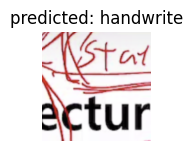

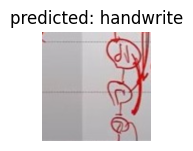

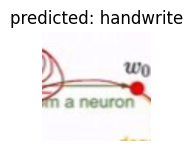

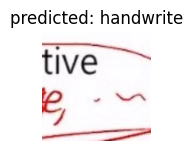

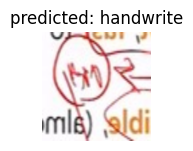

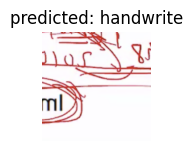

In [11]:
visualize_model(model, test_loader)

plt.ioff()
plt.show()